In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('GOOG.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


In [4]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,718.27,NaN,NaN
1,0.0,718.92,NaN,NaN
2,0.0,710.36,NaN,NaN
3,0.0,691.72,NaN,NaN
4,0.0,693.71,NaN,NaN
...,...,...,...,...
1253,-1.0,2466.09,2451.76,1723.5
1254,-1.0,2482.85,2466.09,1723.5
1255,-1.0,2491.40,2482.85,1723.5
1256,-1.0,2521.60,2491.40,1723.5


In [5]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [6]:
states_buy, states_sell, total_gains, invest = buy_stock(df.close, signals['signal'])

day 153: cannot sell anything, inventory 0
day 154: cannot sell anything, inventory 0
day 155: cannot sell anything, inventory 0
day 185: cannot sell anything, inventory 0
day 186: cannot sell anything, inventory 0
day 187: cannot sell anything, inventory 0
day 188: cannot sell anything, inventory 0
day 189: cannot sell anything, inventory 0
day 190: cannot sell anything, inventory 0
day 191: cannot sell anything, inventory 0
day 216: cannot sell anything, inventory 0
day 217: cannot sell anything, inventory 0
day 219: cannot sell anything, inventory 0
day 220: cannot sell anything, inventory 0
day 221: cannot sell anything, inventory 0
day 222: cannot sell anything, inventory 0
day 223: cannot sell anything, inventory 0
day 224: cannot sell anything, inventory 0
day 226: cannot sell anything, inventory 0
day 231: cannot sell anything, inventory 0
day 232: cannot sell anything, inventory 0
day 237: cannot sell anything, inventory 0
day 238: cannot sell anything, inventory 0
day 239: ca

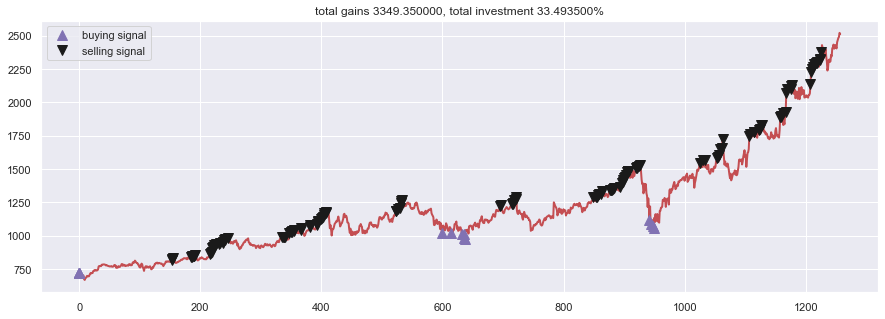

In [7]:
close = df['close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [8]:
df.isnull().sum()

symbol         0
date           0
close          0
high           0
low            0
open           0
volume         0
adjClose       0
adjHigh        0
adjLow         0
adjOpen        0
adjVolume      0
divCash        0
splitFactor    0
dtype: int64

In [9]:
df.describe()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.0
mean,1216.317067,1227.430934,1204.176430,1215.260779,1.601590e+06,1216.317067,1227.430936,1204.176436,1215.260779,1.601590e+06,0.0,1.0
std,383.333358,387.570872,378.777094,382.446995,6.960172e+05,383.333358,387.570873,378.777099,382.446995,6.960172e+05,0.0,0.0
min,668.260000,672.300000,663.284000,671.000000,3.467530e+05,668.260000,672.300000,663.284000,671.000000,3.467530e+05,0.0,1.0
25%,960.802500,968.757500,952.182500,959.005000,1.173522e+06,960.802500,968.757500,952.182500,959.005000,1.173522e+06,0.0,1.0
50%,1132.460000,1143.935000,1117.915000,1131.150000,1.412588e+06,1132.460000,1143.935000,1117.915000,1131.150000,1.412588e+06,0.0,1.0
75%,1360.595000,1374.345000,1348.557500,1361.075000,1.812156e+06,1360.595000,1374.345000,1348.557500,1361.075000,1.812156e+06,0.0,1.0
max,2521.600000,2526.990000,2498.290000,2524.920000,6.207027e+06,2521.600000,2526.990000,2498.290000,2524.920000,6.207027e+06,0.0,1.0


In [10]:
import seaborn as sns
sns.set()

In [11]:
df['close'].value_counts()

1205.50    2
1343.56    2
786.14     2
1095.06    2
786.90     2
          ..
1555.93    1
1027.81    1
782.52     1
1289.92    1
992.00     1
Name: close, Length: 1247, dtype: int64

<AxesSubplot:xlabel='close', ylabel='count'>

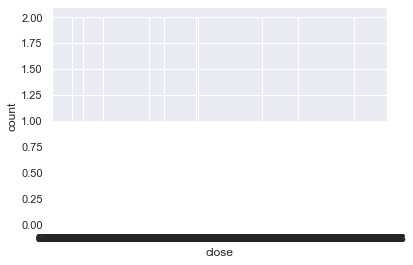

In [12]:
sns.countplot(x='close', data=df)